# Определение стоимости автомобилей

## Подготовка данных

In [1]:
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import lightgbm as lgb
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import GradientBoostingRegressor

# чтобы не было предупреждений
import warnings
warnings.filterwarnings("ignore")

### Анализ данных

In [2]:
df = pd.read_csv(r"C:\Users\George\Мой диск\3 Практикум\2 Проекты\11 Численные методы\autos.csv")

display(df)
df.info()

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,NotRepaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17 00:00:00,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31 00:00:00,0,60437,2016-04-06 10:17:21
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
354364,2016-03-21 09:50:58,0,NaN,2005,manual,0,colt,150000,7,petrol,mitsubishi,yes,2016-03-21 00:00:00,0,2694,2016-03-21 10:42:49
354365,2016-03-14 17:48:27,2200,NaN,2005,NaN,0,NaN,20000,1,NaN,sonstige_autos,NaN,2016-03-14 00:00:00,0,39576,2016-04-06 00:46:52
354366,2016-03-05 19:56:21,1199,convertible,2000,auto,101,fortwo,125000,3,petrol,smart,no,2016-03-05 00:00:00,0,26135,2016-03-11 18:17:12
354367,2016-03-19 18:57:12,9200,bus,1996,manual,102,transporter,150000,3,gasoline,volkswagen,no,2016-03-19 00:00:00,0,87439,2016-04-07 07:15:26


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
DateCrawled          354369 non-null object
Price                354369 non-null int64
VehicleType          316879 non-null object
RegistrationYear     354369 non-null int64
Gearbox              334536 non-null object
Power                354369 non-null int64
Model                334664 non-null object
Kilometer            354369 non-null int64
RegistrationMonth    354369 non-null int64
FuelType             321474 non-null object
Brand                354369 non-null object
NotRepaired          283215 non-null object
DateCreated          354369 non-null object
NumberOfPictures     354369 non-null int64
PostalCode           354369 non-null int64
LastSeen             354369 non-null object
dtypes: int64(7), object(9)
memory usage: 43.3+ MB


In [3]:
# Посмотрим общее распределение:
df.describe()

,Price,RegistrationYear,Power,Kilometer,RegistrationMonth,NumberOfPictures,PostalCode
count,354369.000000,354369.000000,354369.000000,354369.000000,354369.000000,354369.0,354369.000000
mean,4416.656776,2004.234448,110.094337,128211.172535,5.714645,0.0,50508.689087
std,4514.158514,90.227958,189.850405,37905.341530,3.726421,0.0,25783.096248
min,0.000000,1000.000000,0.000000,5000.000000,0.000000,0.0,1067.000000
25%,1050.000000,1999.000000,69.000000,125000.000000,3.000000,0.0,30165.000000
50%,2700.000000,2003.000000,105.000000,150000.000000,6.000000,0.0,49413.000000
75%,6400.000000,2008.000000,143.000000,150000.000000,9.000000,0.0,71083.000000
max,20000.000000,9999.000000,20000.000000,150000.000000,12.000000,0.0,99998.000000


Можно сказать, что минимальная цена и минимальная мощность не может быть равна 0. Также год регистрации не может быть равен 1000.

In [4]:
df.select_dtypes(['object'])

,DateCrawled,VehicleType,Gearbox,Model,FuelType,Brand,NotRepaired,DateCreated,LastSeen
0,2016-03-24 11:52:17,NaN,manual,golf,petrol,volkswagen,NaN,2016-03-24 00:00:00,2016-04-07 03:16:57
1,2016-03-24 10:58:45,coupe,manual,NaN,gasoline,audi,yes,2016-03-24 00:00:00,2016-04-07 01:46:50
2,2016-03-14 12:52:21,suv,auto,grand,gasoline,jeep,NaN,2016-03-14 00:00:00,2016-04-05 12:47:46
3,2016-03-17 16:54:04,small,manual,golf,petrol,volkswagen,no,2016-03-17 00:00:00,2016-03-17 17:40:17
4,2016-03-31 17:25:20,small,manual,fabia,gasoline,skoda,no,2016-03-31 00:00:00,2016-04-06 10:17:21
...,...,...,...,...,...,...,...,...,...
354364,2016-03-21 09:50:58,NaN,manual,colt,petrol,mitsubishi,yes,2016-03-21 00:00:00,2016-03-21 10:42:49
354365,2016-03-14 17:48:27,NaN,NaN,NaN,NaN,sonstige_autos,NaN,2016-03-14 00:00:00,2016-04-06 00:46:52
354366,2016-03-05 19:56:21,convertible,auto,fortwo,petrol,smart,no,2016-03-05 00:00:00,2016-03-11 18:17:12
354367,2016-03-19 18:57:12,bus,manual,transporter,gasoline,volkswagen,no,2016-03-19 00:00:00,2016-04-07 07:15:26


In [5]:
# посмотрим сколько пустых значений
df.isna().sum()

DateCrawled              0
Price                    0
VehicleType          37490
RegistrationYear         0
Gearbox              19833
Power                    0
Model                19705
Kilometer                0
RegistrationMonth        0
FuelType             32895
Brand                    0
NotRepaired          71154
DateCreated              0
NumberOfPictures         0
PostalCode               0
LastSeen                 0
dtype: int64

In [6]:
# посмотрим корреляцию
df.corr()

,Price,RegistrationYear,Power,Kilometer,RegistrationMonth,NumberOfPictures,PostalCode
Price,1.000000,0.026916,0.158872,-0.333199,0.110581,NaN,0.076055
RegistrationYear,0.026916,1.000000,-0.000828,-0.053447,-0.011619,NaN,-0.003459
Power,0.158872,-0.000828,1.000000,0.024002,0.043380,NaN,0.021665
Kilometer,-0.333199,-0.053447,0.024002,1.000000,0.009571,NaN,-0.007698
RegistrationMonth,0.110581,-0.011619,0.043380,0.009571,1.000000,NaN,0.013995
NumberOfPictures,NaN,NaN,NaN,NaN,NaN,NaN,NaN
PostalCode,0.076055,-0.003459,0.021665,-0.007698,0.013995,NaN,1.000000


**Вывод**<br>
Из общего распределения можно увидеть, что:
- В столбцах `'Price', 'Power'`  минимальное значение равняется 0, что очень не логично, нужно построить boxplot, гистограмму, чтобы посмотреть распределение
- В столбце `'RegistrationYear'` минимальное значение равняется 1000, что не возвожно.
- Столбцы `'RegistrationMonth', 'NumberOfPictures', 'PostalCode'` нам не интересны, поэтому их мы не будем редактировать.
- Столбец `'NotRepaired'` имеет два уникальных значения: `yes, no`. Можно заменить на 1, 0
- Присутствую пропуски в 4 столбцах: `VehicleType, Gearbox, Model, NotRepaired`. Нужно просмотреть распределение там и по возможность заполнить пропуски.
- Корреляция между признаками слабая.

### Обработка данных
Начнём редактирование данных для машинного обучения. Для этого создадим DataFrame `data`

Оставим признаки которые нам понадобятся при обучении модели.<br>
Из всех признаков:
- `DateCrawled` — дата скачивания анкеты из базы
- `VehicleType` — тип автомобильного кузова
- `RegistrationYear` — год регистрации автомобиля
- `Gearbox` — тип коробки передач
- `Power` — мощность (л. с.)
- `Model` — модель автомобиля
- `Kilometer` — пробег (км)
- `RegistrationMonth` — месяц регистрации автомобиля
- `FuelType` — тип топлива
- `Brand` — марка автомобиля
- `NotRepaired` — была машина в ремонте или нет
- `DateCreated` — дата создания анкеты
- `NumberOfPictures` — количество фотографий автомобиля
- `PostalCode` — почтовый индекс владельца анкеты (пользователя)
- `LastSeen` — дата последней активности пользователя
- `Price` — цена (евро)


Оставляем:
- `Brand` — марка автомобиля
- `Model` — модель автомобиля
- `VehicleType` — тип автомобильного кузова
- `Gearbox` — тип коробки передач
- `Power` — мощность (л. с.)
- `FuelType` — тип топлива
- `RegistrationYear` — год регистрации автомобиля
- `Kilometer` — пробег (км)
- `NotRepaired` — была машина в ремонте или нет
- `Price` — цена (евро) 

In [7]:
data = df[[
    'Brand',
    'Model',
    'VehicleType',
    'Gearbox',
    'Power',
    'FuelType',
    'RegistrationYear',
    'Kilometer',
    'NotRepaired',
    'Price'
]]

data.shape

(354369, 10)

In [8]:
# Проверим на наличие дубликатов
data.duplicated().sum()

45040

In [9]:
# Удалим их
data = data.drop_duplicates()

#### Ограничения

Посмотрим распределение и уберём выбросы

In [10]:
data.head()

,Brand,Model,VehicleType,Gearbox,Power,FuelType,RegistrationYear,Kilometer,NotRepaired,Price
0,volkswagen,golf,NaN,manual,0,petrol,1993,150000,NaN,480
1,audi,NaN,coupe,manual,190,gasoline,2011,125000,yes,18300
2,jeep,grand,suv,auto,163,gasoline,2004,125000,NaN,9800
3,volkswagen,golf,small,manual,75,petrol,2001,150000,no,1500
4,skoda,fabia,small,manual,69,gasoline,2008,90000,no,3600


In [11]:
data.describe()

,Power,RegistrationYear,Kilometer,Price
count,309329.000000,309329.000000,309329.000000,309329.000000
mean,110.976908,2004.360105,127217.735809,4486.937196
std,200.969473,92.541399,38532.941010,4564.852796
min,0.000000,1000.000000,5000.000000,0.000000
25%,69.000000,1999.000000,125000.000000,1100.000000
50%,105.000000,2003.000000,150000.000000,2800.000000
75%,143.000000,2008.000000,150000.000000,6500.000000
max,20000.000000,9999.000000,150000.000000,20000.000000


**RegistrationYear**

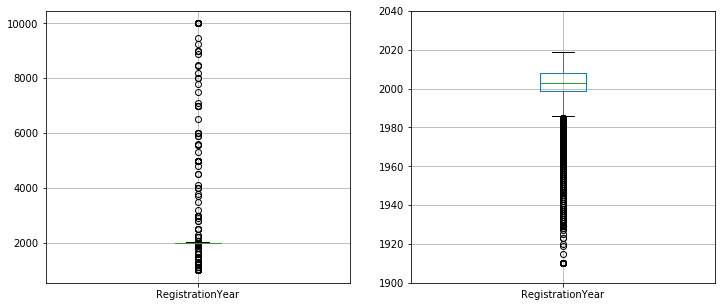

In [12]:
# распределение в столбце RegistrationYear
fig, axes = plt.subplots(1, 2, figsize = (12,5))

plt.subplot(1,2,1)
data.boxplot(column='RegistrationYear')

plt.subplot(1,2,2)
data.boxplot(column='RegistrationYear')
plt.ylim(1900, 2040)

plt.show()

In [13]:
# посмотрим с 1900 по 2040
data[(data['RegistrationYear'] >=1900) & (data['RegistrationYear'] <= 2022)].sort_values(by='RegistrationYear')

,Brand,Model,VehicleType,Gearbox,Power,FuelType,RegistrationYear,Kilometer,NotRepaired,Price
48958,opel,agila,small,manual,0,NaN,1910,5000,yes,600
318111,volkswagen,golf,NaN,NaN,0,NaN,1910,125000,NaN,1
82829,opel,corsa,NaN,NaN,0,NaN,1910,150000,NaN,500
78374,audi,NaN,other,NaN,0,NaN,1910,5000,NaN,250
200148,audi,a4,NaN,NaN,0,NaN,1910,150000,NaN,0
...,...,...,...,...,...,...,...,...,...,...
61345,hyundai,i_reihe,NaN,NaN,0,gasoline,2019,30000,no,19490
178620,volkswagen,polo,NaN,manual,90,petrol,2019,5000,no,15500
126686,bmw,5er,NaN,manual,1,NaN,2019,150000,NaN,0
62996,volkswagen,passat,NaN,auto,170,NaN,2019,150000,no,7900


Можно сделать вывод, что данные были введены неправильно, поэтому ограничим годы с 1985 по 2022:

In [14]:
data = data[(data['RegistrationYear'] >= 1985) & (data['RegistrationYear'] <= 2022)]

**Power**

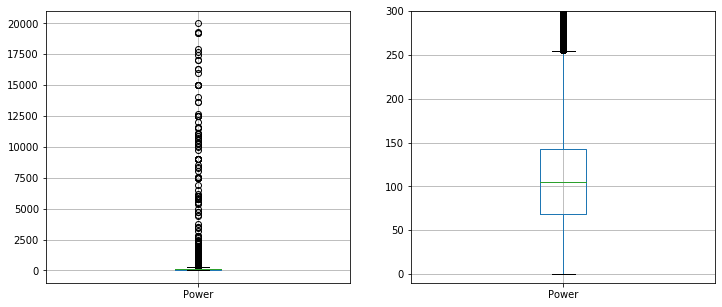

In [15]:
# распределение в столбце Power
fig, axes = plt.subplots(1, 2, figsize = (12,5))

plt.subplot(1,2,1)
data.boxplot(column='Power')

plt.subplot(1,2,2)
data.boxplot(column='Power')
plt.ylim(-10, 300)

plt.show()

In [16]:
power = data['Power'].value_counts().reset_index().sort_values(by='index', ascending=True)
power_df = pd.DataFrame(power)
power_df.rename(columns={'index': 'Power', 'Power': 'Quantity'}, inplace=True)

power_df

,Power,Quantity
0,0,34346
232,1,28
294,2,9
319,3,7
237,4,26
...,...,...
497,17932,1
504,19208,1
501,19211,1
614,19312,1


Имеет смысл поставить ограничения с 50 л.с. до 1200 л.с.

In [17]:
data = data[(data['Power'] >= 50) & (data['Power'] <= 1200)]

**Kilometer**

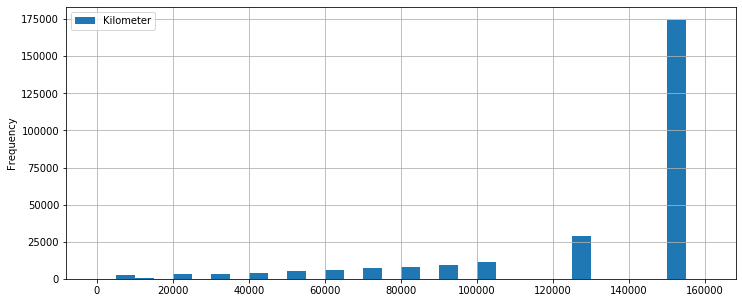

[5000, 10000, 20000, 30000, 40000, 50000, 60000, 70000, 80000, 90000, 100000, 125000, 150000]


In [18]:
# распределение в столбце Kilometer
data.plot(kind='hist',
         y='Kilometer',
         range=(0, 160000),
         bins=32,
         figsize=(12, 5),
         grid=True,
         label='Kilometer')
plt.show()

print(sorted(data['Kilometer'].unique()))

Тут ничего странного нет. Да, большинство машин имеют пробег в 125000, 150000 км

**Price**

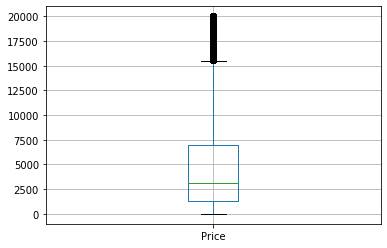

In [19]:
# Проанализируем цену на автомобили
data.boxplot(column='Price')

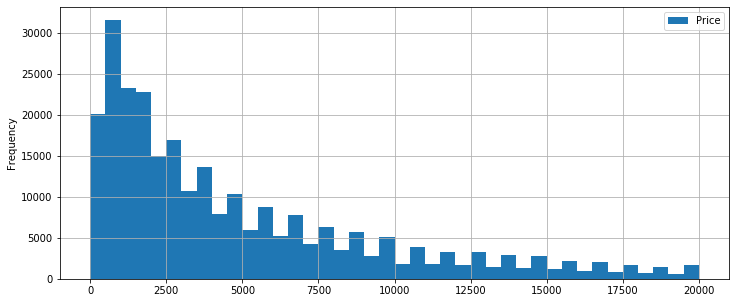

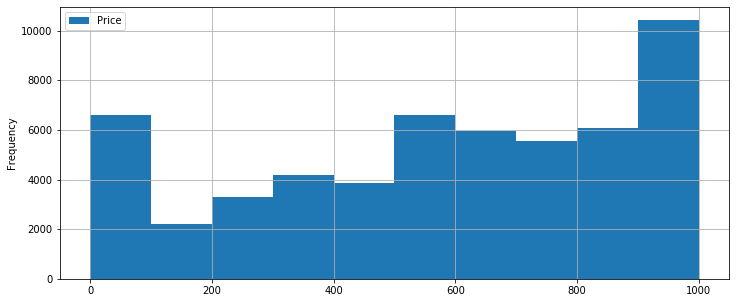

In [20]:
# Распределение в столбце Price
data.plot(kind='hist',
        y='Price',
        bins=40,
        figsize = (12, 5),
        grid=True,
        label='Price')

data.plot(kind='hist',
        y='Price',
        bins=10,
        range = (0, 1000),
        figsize = (12, 5),
        grid=True,
        label='Price')

Можно увидеть, что очень много машин с ценой 0, что не может быть. Имеет смысл ограничить с 900 у.е.

In [21]:
# Удалим выбросы
data = data[data['Price'] > 900]

In [22]:
#код ревьюера
data.describe()

,Power,RegistrationYear,Kilometer,Price
count,218588.000000,218588.000000,218588.000000,218588.000000
mean,128.951891,2004.641618,125677.004227,5733.569025
std,55.755841,5.866832,37912.740764,4606.392864
min,50.000000,1985.000000,5000.000000,901.000000
25%,90.000000,2001.000000,100000.000000,2100.000000
50%,120.000000,2005.000000,150000.000000,4100.000000
75%,150.000000,2008.000000,150000.000000,7999.000000
max,1164.000000,2019.000000,150000.000000,20000.000000


#### Пропуски

In [23]:
data.shape

(218588, 10)

In [24]:
data.isna().sum()

Brand                   0
Model                7887
VehicleType         13777
Gearbox              3731
Power                   0
FuelType            12506
RegistrationYear        0
Kilometer               0
NotRepaired         29894
Price                   0
dtype: int64

Как мы видим данные параметры имеют такое количество пропусков:

 - `Model` (модель автомобиля) - 7 887
 - `VehicleType` (тип автомобильного кузова) - 13 777
 - `Gearbox` (тип коробки передач) - 3 731
 - `FuelType` (тип топлива) - 12 506
 - `NotRepaired` (была машина в ремонте или нет) - 29 894

Нужно заполнить или удалить пропуски эти пропуски, т.к. при обучении модели будут возникать ошибки. А также параметр `NotRepaired` для нас важен, поэтому в нём не может быть пропусков

**VehicleType**

In [25]:
# исследуем кузов машины
VehicleType = data['VehicleType'].value_counts()
display(VehicleType)
print(f'Машины класса седан составляют {VehicleType[0]/VehicleType.sum()*100}%')

sedan          59862
wagon          44010
small          41473
bus            21817
convertible    15488
coupe          10990
suv             9423
other           1748
Name: VehicleType, dtype: int64

Машины класса седан составляют 29.227922328390566%


Можно сделать вывод, что машины класса седан больше всего поэтому имеет смысл заполнить пропуски именно им

**Gearbox**

In [26]:
# исследуем трансмиссию машины
Gearbox = data['Gearbox'].value_counts()
display(Gearbox)
print(f'Машины на механике составляют {Gearbox[0] / Gearbox.sum()*100}%')

manual    166216
auto       48641
Name: Gearbox, dtype: int64

Машины на механике составляют 77.36122164974843%


И также можно увидеть, что машин на механике в 4 раза больше, чем на автомате.

**FuelType**

In [27]:
# исследуем топливо автомобиля
FuelType = data['FuelType'].value_counts()
display(FuelType)
print(f'В {(FuelType[0]/FuelType.sum()*100).round(2)}% машин ездят на бензине')

petrol      128183
gasoline     73298
lpg           3924
cng            421
hybrid         185
other           41
electric        30
Name: FuelType, dtype: int64

В 62.2% машин ездят на бензине


Пропуски можно заполнить 'petrol'

**NotRepaired**

In [28]:
data = data.replace({'NotRepaired' : { 'yes' : 1, 'no' : 0}})

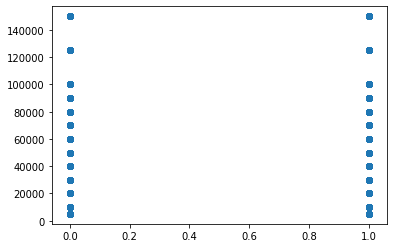

In [29]:
plt.scatter(data['NotRepaired'], data['Kilometer'])

In [30]:
print('Пропусков:', data['NotRepaired'].isna().sum())
NotRepaired = data['NotRepaired'].value_counts()
display(NotRepaired)

print(f'Только {(NotRepaired[1] / NotRepaired.sum()*100).round(2)}% машин были в ремонте')

Пропусков: 29894


0.0    173681
1.0     15013
Name: NotRepaired, dtype: int64

Только 7.96% машин были в ремонте


In [31]:
# Заполним пропуски
data['VehicleType'] = data['VehicleType'].fillna('sedan')
data['Gearbox'] = data['Gearbox'].fillna('manual')
data['FuelType'] = data['FuelType'].fillna('petrol')

In [32]:
# заполним пропуски с ремонтом - 'yes' свыше 100 000 км пробега
data.loc[data['NotRepaired'].isna(), 'NotRepaired'] = data.loc[data['NotRepaired'].isna(), 'NotRepaired'] \
    .apply(lambda x: 'no' if x > 1000000 else 'yes')

In [33]:
# удалим оставшие пропуски в столбце model и проверим
data = data.dropna()
data.isna().sum()

Brand               0
Model               0
VehicleType         0
Gearbox             0
Power               0
FuelType            0
RegistrationYear    0
Kilometer           0
NotRepaired         0
Price               0
dtype: int64

In [34]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 210701 entries, 2 to 354368
Data columns (total 10 columns):
Brand               210701 non-null object
Model               210701 non-null object
VehicleType         210701 non-null object
Gearbox             210701 non-null object
Power               210701 non-null int64
FuelType            210701 non-null object
RegistrationYear    210701 non-null int64
Kilometer           210701 non-null int64
NotRepaired         210701 non-null object
Price               210701 non-null int64
dtypes: int64(4), object(6)
memory usage: 17.7+ MB


Получение дамми-признаков

In [35]:
data = pd.get_dummies(data, drop_first=True)

In [36]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 210701 entries, 2 to 354368
Columns: 304 entries, Power to NotRepaired_yes
dtypes: int64(4), uint8(300)
memory usage: 68.3 MB


**Вывод**<br>
- Проанализировал данные и удалил дубликаты.
- Создал таблицу с нужными для нас признаками 
- Очистили от выбросов параметры *Price* и *Power*
- Получил дамми-признаки

## Обучение моделей

Разобьём на выборки

In [37]:
features = data.drop(['Price'], axis=1)
target = data['Price']

features_train, features_valid, target_train, target_valid = train_test_split(features, target, test_size=0.25, random_state=12345)

print(features_train.shape)
print(features_valid.shape)
print(target_train.shape)
print(target_valid.shape)

(158025, 303)
(52676, 303)
(158025,)
(52676,)


In [38]:
# создадим списки для rsme, время обучения, время предсказания
rmse_list = []
learning_time = []
predict_time = []

### Линейная регрессия

In [39]:
model_lr = LinearRegression()

In [40]:
%%time
start = time.time()
model_lr.fit(features_train, target_train)
end = time.time()
linear_time = end - start

learning_time.append(linear_time)

Wall time: 3.41 s


In [41]:
# Предсказание
start = time.time()
predict_valid = model_lr.predict(features_valid)
end = time.time()

predict = end - start
rmse = mean_squared_error(target_valid, predict_valid)**0.5

predict_time.append(predict)
rmse_list.append(rmse)

print(predict_time)
print(rmse)

[0.08790111541748047]
2594.213681506243


### LightGBM

In [42]:
GBM_model = lgb.LGBMRegressor(random_state=12345)

In [43]:
%%time

start = time.time()
GBM_model.fit(features_train, target_train, eval_set=[(features_train, target_train)], eval_metric=["rmse"], verbose=10)
end = time.time()
linear_time = end - start

learning_time.append(linear_time)

[10]	training's rmse: 2689.74	training's l2: 7.23473e+06
[20]	training's rmse: 2122.59	training's l2: 4.50539e+06
[30]	training's rmse: 1919.79	training's l2: 3.68559e+06
[40]	training's rmse: 1824.93	training's l2: 3.33038e+06
[50]	training's rmse: 1772.87	training's l2: 3.14305e+06
[60]	training's rmse: 1742.66	training's l2: 3.03688e+06
[70]	training's rmse: 1722.83	training's l2: 2.96813e+06
[80]	training's rmse: 1707.56	training's l2: 2.91575e+06
[90]	training's rmse: 1694.84	training's l2: 2.87248e+06
[100]	training's rmse: 1683.35	training's l2: 2.83367e+06
Wall time: 749 ms


Можно сделать вывод, что модель LightGBM обучилась лучше.

In [44]:
# Предсказание
start = time.time()
predict_valid = GBM_model.predict(features_valid)
end = time.time()

predict = end - start
rmse = mean_squared_error(target_valid, predict_valid)**0.5

predict_time.append(predict)
rmse_list.append(rmse)

print(predict_time)
print(rmse)

[0.08790111541748047, 0.1773972511291504]
1692.6421988554623


---

## Анализ моделей

Изменим модель градиентного бустинга с помощью GridSearchCV

    %%time

    params = {
        'max_depth': [-1, 3, 6],
        'n_estimators': [50, 100, 200, 500],
    }

    grid = GridSearchCV(GBM_model, params, scoring='neg_mean_squared_error', cv=5)
    grid.fit(features_train, target_train)

    grid.best_params_

    CPU times: user 1h 12min 43s, sys: 32.5 s, total: 1h 13min 16s
    Wall time: 1h 13min 53s
    {'max_depth': -1, 'n_estimators': 500}

Делаем вывод, что лучшие параметр это 500 и меняем модель

In [45]:
GBM_model = lgb.LGBMRegressor(random_state=12345, n_estimators=500)

In [46]:
%%time

start = time.time()
GBM_model.fit(features_train, target_train, eval_set=[(features_train, target_train),], eval_metric=["rmse"], verbose=50)
end = time.time()
linear_time = end - start

learning_time.append(linear_time)

[50]	training's rmse: 1772.87	training's l2: 3.14305e+06
[100]	training's rmse: 1683.35	training's l2: 2.83367e+06
[150]	training's rmse: 1646.68	training's l2: 2.71156e+06
[200]	training's rmse: 1620.96	training's l2: 2.62751e+06
[250]	training's rmse: 1600.28	training's l2: 2.56091e+06
[300]	training's rmse: 1585.48	training's l2: 2.51375e+06
[350]	training's rmse: 1573.05	training's l2: 2.47447e+06
[400]	training's rmse: 1561.9	training's l2: 2.43954e+06
[450]	training's rmse: 1552.83	training's l2: 2.41127e+06
[500]	training's rmse: 1540.96	training's l2: 2.37457e+06
Wall time: 1.36 s


In [47]:
# Предсказание
start = time.time()
predict_valid = GBM_model.predict(features_valid)
end = time.time()

predict = end - start
rmse = mean_squared_error(target_valid, predict_valid)**0.5

predict_time.append(predict)
rmse_list.append(rmse)

print(predict_time)
print(rmse)

[0.08790111541748047, 0.1773972511291504, 0.39708876609802246]
1600.0509997065858


Итак, посмотрим на таблицу метрики и времён:

In [48]:
pd.DataFrame(data=[rmse_list, learning_time, predict_time], columns=['LinearRegression', 'LGBMRegressor', 'LGBMRegressor_upgrade'], index=['RMSE', 'Learning Time', 'Predicting Time'])

,LinearRegression,LGBMRegressor,LGBMRegressor_upgrade
RMSE,2594.213682,1692.642199,1600.051000
Learning Time,3.410343,0.748880,1.357563
Predicting Time,0.087901,0.177397,0.397089


**Вывод:**

Можно сделать вывод, что хоть и модель `LGBMRegressor_upgrade` обучалась намного дольше, но результат лучше, её и будем рекомендовать заказчику.